# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)


[Feature Selection](#Feature-selection-&-encoding)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Modeli-linearne-regresije)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#MultitaskLasso-Regresija-(3-izlaza))
    
    -[Ridge](#Ridge-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [1]:
#%% Imports


#SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 

import squarify
from sklearn.pipeline import Pipeline


# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')



# Import dataseta

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

df['AVERAGE'] = df[['math score', 'reading score','writing score']].mean(axis=1)

# Vizualizacija podataka

In [3]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,AVERAGE
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [4]:
df.shape

(1000, 9)

## Kategoričke značajke

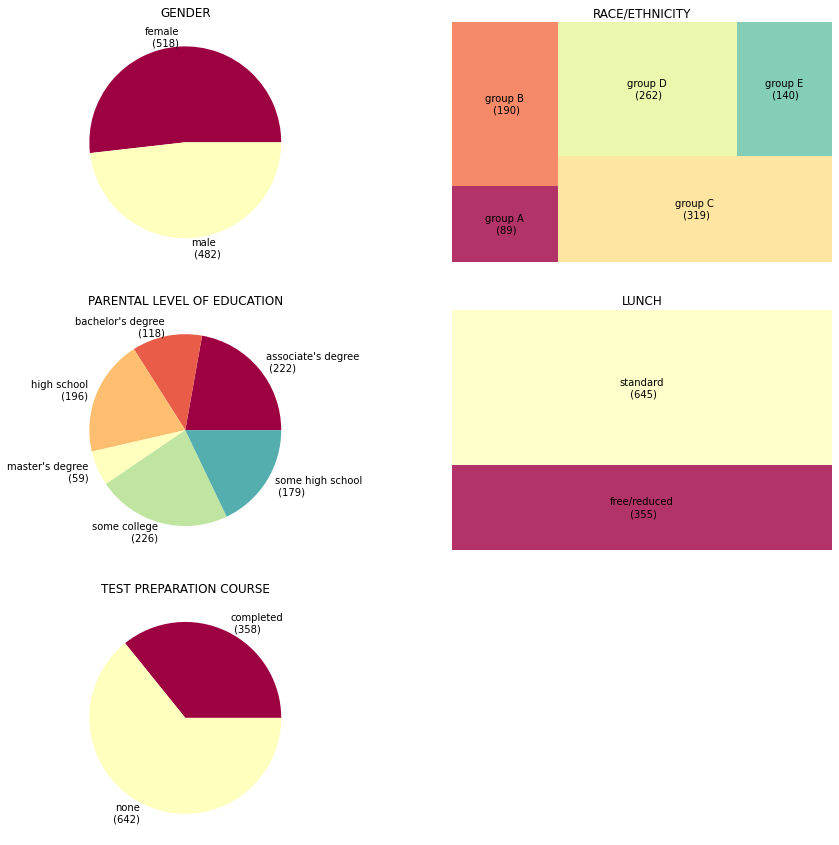

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Numeričke značajke 

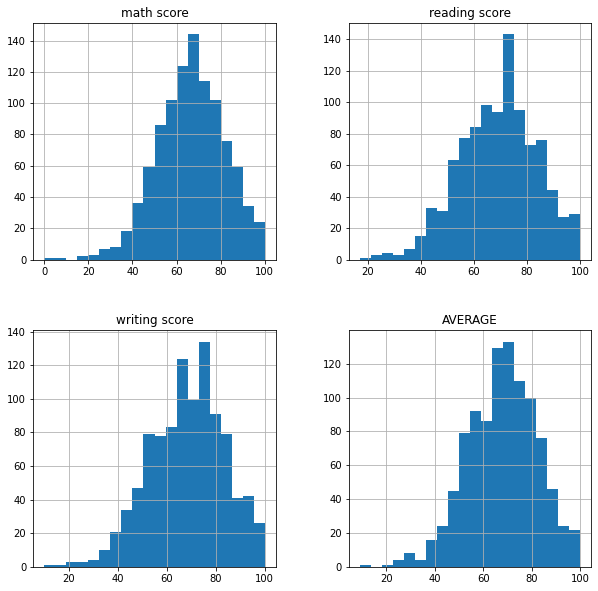

In [6]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

## Usporedba spola

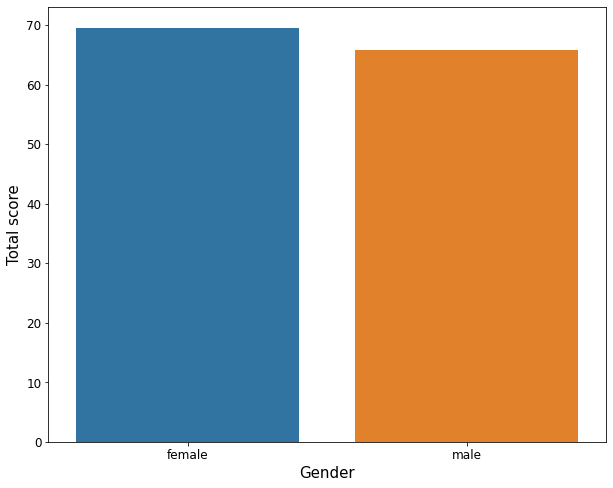

In [7]:
df['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
plt.figure(figsize = (10,8))
sns.barplot(data = df, x = 'gender', y = 'Total score', ci = False)
plt.xticks(fontsize = 12)
plt.xlabel('Gender', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Total score', fontsize = 15)
plt.show()

 
    

## Utjecaj priprema za ispit na rezultate 

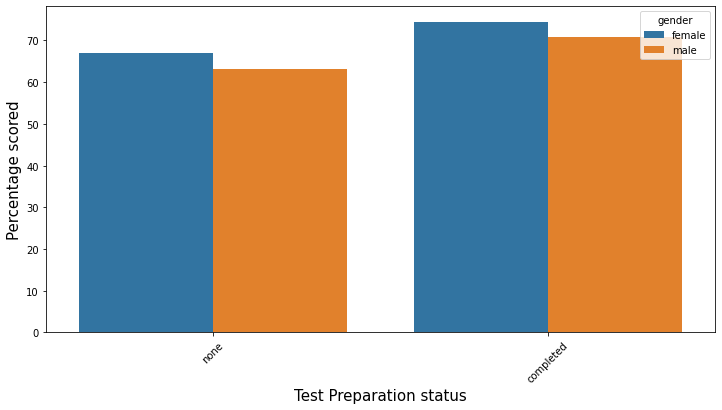

In [8]:
plt.figure(figsize = (12,6))
sns.barplot(data = df, x = 'test preparation course', y = 'Total score', hue = 'gender', ci = False)
plt.xlabel('Test Preparation status', fontsize = 15)
plt.xticks(rotation = 45)
plt.ylabel('Percentage scored', fontsize = 15)
plt.show()

df = df.drop(["Total score"],axis = 'columns')

# Feature selection & encoding

## Kodiranje atributa

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Biblioteka LabelEncoder
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [9]:
# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


In [10]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to change our code in multiple places
    return pd.get_dummies(data, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })




def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    #target= table["AVERAGE"]
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        #return one_hot_encoding(table)
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        return find_and_replace(table)
    
#Kako koristiti:

#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## Feature selection

In [11]:
def odaberi(algorithm,k,train_X, train_y,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(train_X, train_y)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(train_X.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, train_X.shape[1]])
    plt.xticks(range(train_X.shape[1]), train_X.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

### 1.Odabir encodinga za feature selection : ONE HOT ENCODING

In [12]:
X_features_encoded = encode_data(df,enc_type="ONEHOT")
Y = df["AVERAGE"]
k_best = int(len(X_features_encoded.columns)*0.8) 

In [13]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')


### Rezultat s metodom: f_regression

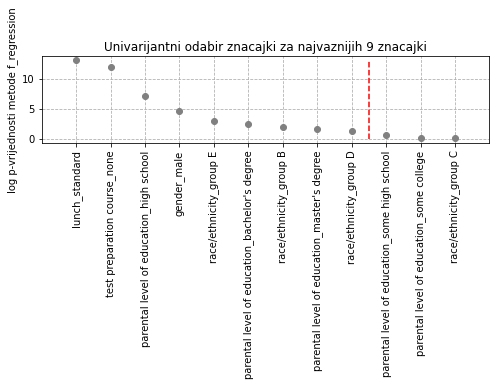

In [14]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

### Rezultat s metodom: chi2

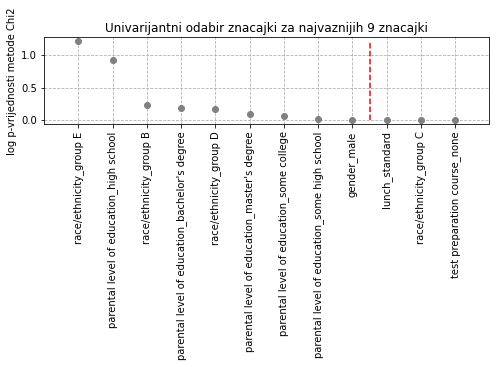

In [15]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

### 2.Odabir encodinga za feature selection : LABEL


In [16]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

k_best = int(len(X_features_encoded.columns)*0.8) 

In [17]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')

### Rezultat s metodom: f_regression

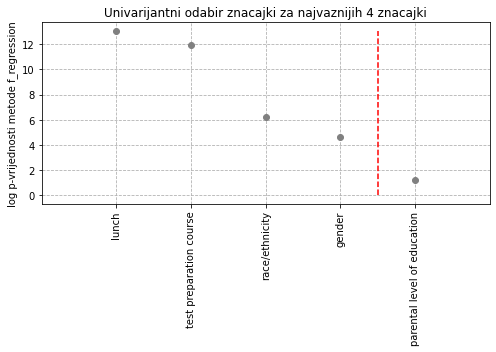

In [18]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

### Rezultat s metodom: chi2

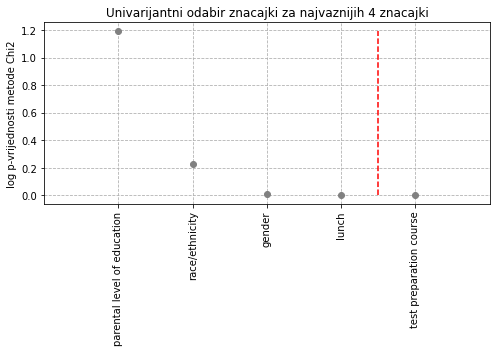

In [19]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

### Funkcije za ispis grešaka

In [20]:
def residual(true,pred):
    resid = true - pred
    print( np.sqrt(np.mean(resid*resid)) )
def evaluateRegressor(true,predicted,message = "Test set"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")

### Train Test Split
Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

In [21]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

Y_class= pd.cut(Y,
       5, labels=[1,2,3,4,5])

train_X, valid_X, train_y, valid_y = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

#train_y_N=train_y_N.astype('int')

In [22]:
df_temp = df.copy()
df_temp['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
df_temp=df_temp.drop(["AVERAGE"],axis = 'columns')

In [23]:
df2 = one_hot_encoding(df_temp)
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

Ako ce nam trebat skalirani podaci ,tu su

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)

## Modeli linearne regresije

Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

### Linearna Regresija

In [25]:
model = Pipeline([ ('linear', LinearRegression()) ])
model = model.fit(features, targets)

regr_pred = model.predict(test.loc[:, 'gender' : 'test preparation course'])
print(regr_pred)

correct_scores = test.loc[:, 'math score' : 'Total score']
explained_variance = explained_variance_score(correct_scores, regr_pred)
R2 = r2_score(correct_scores, regr_pred)
MSE = mean_squared_error(correct_scores, regr_pred)

print('Objasnjena varijanca = '+'{0:.2f}'.format(explained_variance)+'\nR2 = '+'{0:.2f}'.format(R2)+'\nMSE = '+'{0:.2f}'.format(MSE))

[[60.03411265 67.27410766 64.86005934 64.05655282]
 [61.98816095 68.39951706 65.96169682 65.44941147]
 [72.31745226 80.12134538 84.31763122 78.91854872]
 [53.12986366 63.26856836 61.31320243 59.23717469]
 [69.37473496 65.17187348 63.80633934 66.1176093 ]
 [65.22195082 72.29319004 71.07647828 69.53071664]
 [49.97493115 61.48210379 58.24082905 56.56631766]
 [77.9963522  75.37046686 76.8660181  76.74444721]
 [79.2264724  72.90425965 70.82378482 74.31812151]
 [69.08267128 63.93202179 61.60008709 64.87172981]
 [63.99309274 70.98568487 70.48543585 68.48781418]
 [61.16667563 75.61973845 77.26934395 71.35194139]
 [85.96397862 79.12890356 79.89955695 81.66413565]
 [57.89148367 70.03334351 70.98592559 66.30354741]
 [62.63722875 58.94722958 54.73056721 58.77159516]
 [71.74170988 69.93391417 68.31810267 69.99747662]
 [74.08024811 77.42413874 75.72497267 75.74295342]
 [66.98008986 63.16913902 58.64537951 62.9311039 ]
 [80.97482532 87.91520302 90.15202416 86.34696167]
 [67.55583225 73.35657023 74.64

In [26]:
def lin_reg(X,y):
    LinearReg = LinearRegression(normalize = True)
    LinearReg = LinearReg.fit(X,y)

    return LinearReg


In [27]:
model_LINEAR = lin_reg(train_X,train_y)

predicted_valid_y = model_LINEAR.predict(valid_X)

In [28]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

12.48878197891483
Test set
MSE: 155.9696753168678
MAE: 9.972645125317916
RMSE: 12.48878197891483
R-squared: 0.13477459309591522 , from <0,1> 


### MultitaskLasso Regresija (3 izlaza)

In [29]:
X_lasso =df.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =df[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [30]:
train_X_lasso, valid_X_lasso, train_y_lasso, valid_y_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

In [31]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
#MTL.fit([[1, 0], [1, 3], [2, 2]], [[0, 2], [1, 4], [2, 4]])
MTL.fit(train_X_lasso,train_y_lasso)

pred=MTL.predict(valid_X_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(valid_X_lasso), "\n")
  
# print the coefficients
#print("Coefficients: \n", MTL.coef_, "\n")
  
# print the intercepts
#print("Intercepts: \n", MTL.intercept_, "\n")
  
# print the number of iterations performed
#print("Number of Iterations: ", MTL.n_iter_, "\n")

In [32]:
residual(valid_y_lasso, pred)

print("\nScores:")
evaluateRegressor(valid_y_lasso, pred)

math score       13.623600
reading score    13.935680
writing score    13.541493
dtype: float64

Scores:
Test set
MSE: 187.72589465164185
MAE: 10.947498704598301
RMSE: 13.700257637032381
R-squared: 0.16810796619924104 , from <0,1> 


## Ridge regresija

Objasnjena varijanca = 0.26
R2 = 0.26
MSE = 174.48


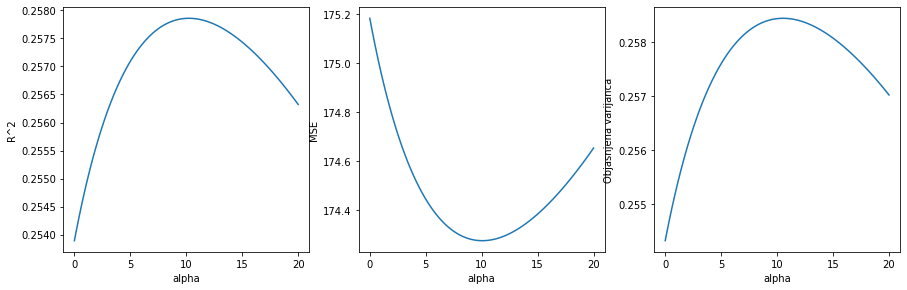

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
alpha_array = np.linspace(0.01, 20.0, 100)
R2 = []
MSE = []
explained_variance = []

for alpha in alpha_array:
    model_ridge = Pipeline( [ ('ridge', Ridge(alpha=alpha)) ] )
    model_ridge = model_ridge.fit(features, targets)
    #R2_ridge = model_ridge.score(test.loc[:, 'gender' : 'test preparation course'], correct_scores)
    regr_pred = model_ridge.predict(test.loc[:, 'gender' : 'test preparation course'])
    explained_variance.append(explained_variance_score(correct_scores, regr_pred))
    R2.append(r2_score(correct_scores, regr_pred))
    MSE.append(mean_squared_error(correct_scores, regr_pred))

def avg(arr):
    return sum(arr) / len(arr)

print('Objasnjena varijanca = '+'{0:.2f}'.format(avg(explained_variance))+'\nR2 = '+'{0:.2f}'.format(avg(R2))+'\nMSE = '+'{0:.2f}'.format(avg(MSE)))
ax[0].plot(alpha_array, R2)
ax[0].set(xlabel='alpha', ylabel='R^2')
ax[1].plot(alpha_array, MSE)
ax[1].set(xlabel='alpha', ylabel='MSE')
ax[2].plot(alpha_array, explained_variance)
ax[2].set(xlabel='alpha', ylabel='Objasnjena varijanca')

plt.show()

## XGBoost

## LightGBM

In [34]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(train_X,train_y)

predicted_train_y = LGBMReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LGBMReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

    Training Set
MSE: 136.62946975410622
MAE: 9.378511717372376
RMSE: 11.688860926288164
R-squared: 0.3384019985043043 , from <0,1> 
    Test Set
MSE: 170.87290119417526
MAE: 10.354070378606702
RMSE: 13.071836182961261
R-squared: 0.05210051143433547 , from <0,1> 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

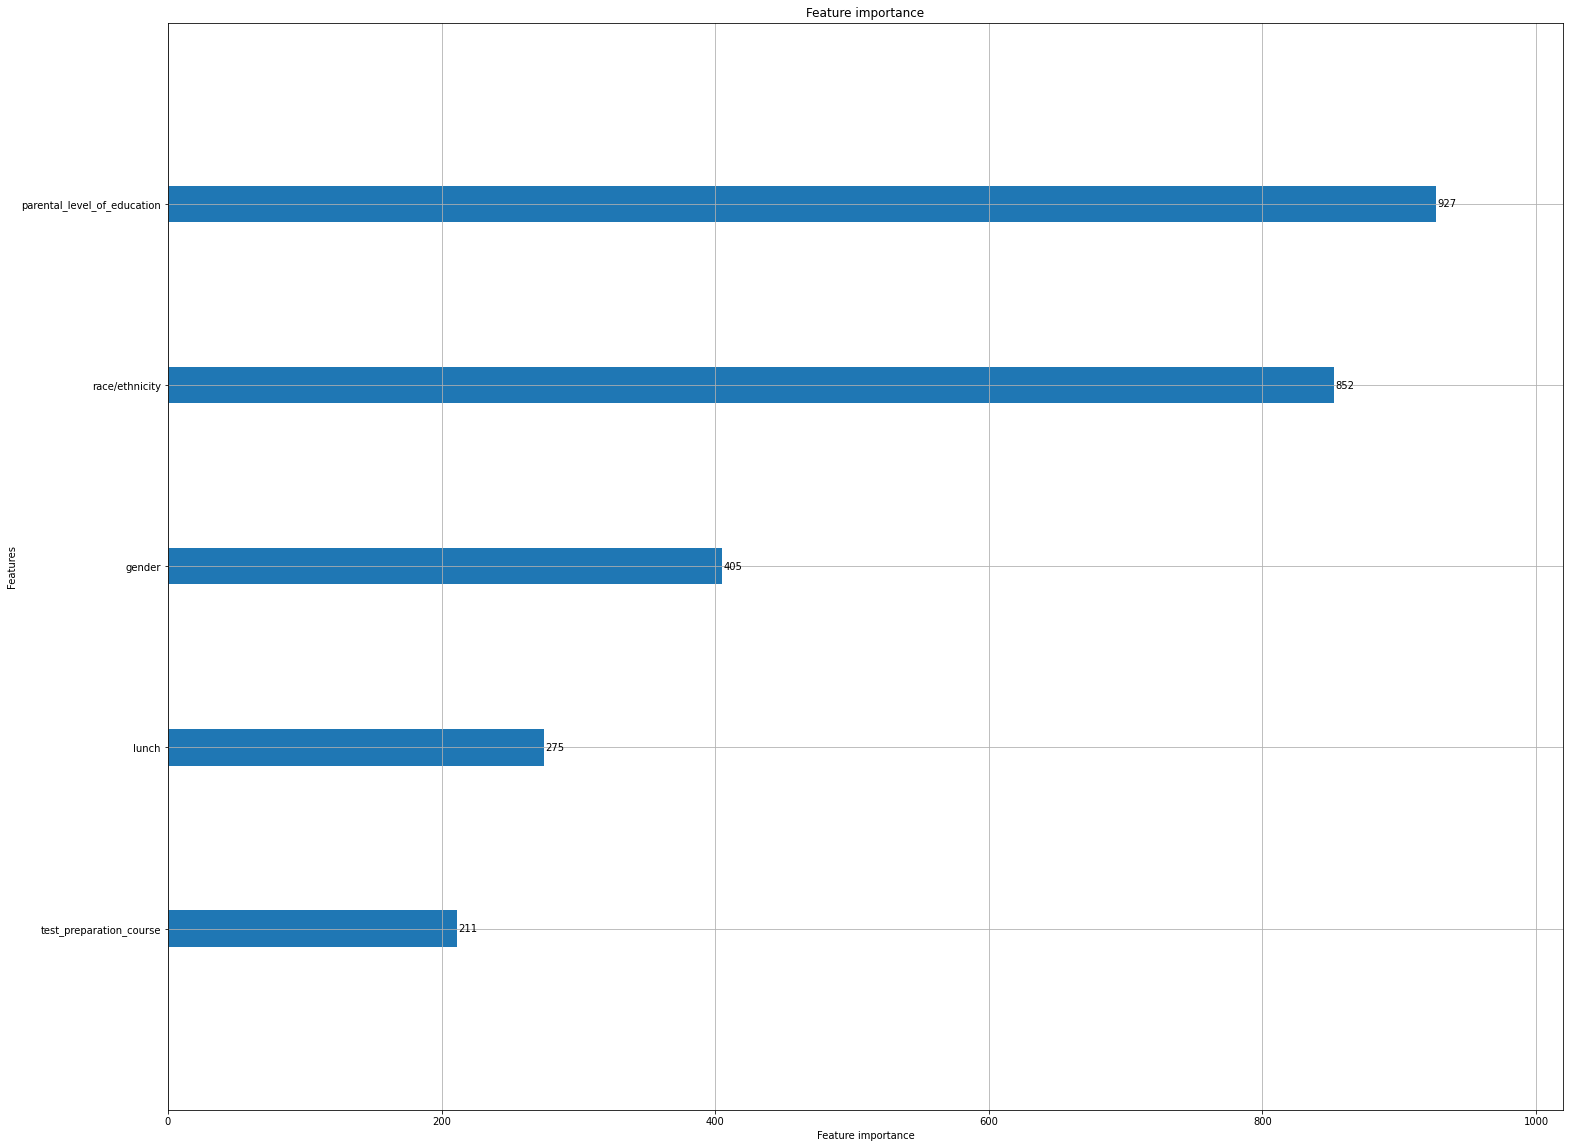

In [35]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

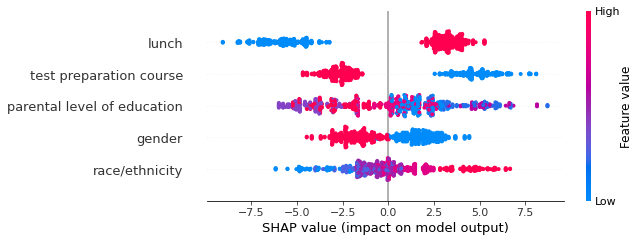

In [36]:
#LGBMReg.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(LGBMReg).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

## CATBoost

In [37]:
from catboost import CatBoostRegressor
# Initialize data

train_data = train_X

eval_data = valid_X

train_labels = train_y

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=200,
                          learning_rate=1,
                          depth=2)
# Fit model
model.fit(train_data, train_labels)


0:	learn: 13.1719877	total: 136ms	remaining: 27.1s
1:	learn: 12.8803549	total: 137ms	remaining: 13.6s
2:	learn: 12.6910379	total: 138ms	remaining: 9.07s
3:	learn: 12.6092057	total: 139ms	remaining: 6.81s
4:	learn: 12.5912744	total: 142ms	remaining: 5.53s
5:	learn: 12.5741885	total: 143ms	remaining: 4.62s
6:	learn: 12.5582826	total: 144ms	remaining: 3.96s
7:	learn: 12.5462713	total: 145ms	remaining: 3.47s
8:	learn: 12.5270601	total: 146ms	remaining: 3.09s
9:	learn: 12.4937532	total: 147ms	remaining: 2.78s
10:	learn: 12.4610152	total: 147ms	remaining: 2.53s
11:	learn: 12.4507256	total: 148ms	remaining: 2.32s
12:	learn: 12.4427831	total: 149ms	remaining: 2.15s
13:	learn: 12.4273182	total: 151ms	remaining: 2s
14:	learn: 12.4209541	total: 152ms	remaining: 1.87s
15:	learn: 12.4086981	total: 153ms	remaining: 1.75s
16:	learn: 12.4032934	total: 154ms	remaining: 1.65s
17:	learn: 12.3932314	total: 155ms	remaining: 1.56s
18:	learn: 12.3888057	total: 156ms	remaining: 1.49s
19:	learn: 12.3875888	tot

In [38]:
# Get predictions
pred_train= model.predict(train_data)
pred = model.predict(eval_data)

In [39]:
residual(valid_y, pred)

print("\nScores:")
evaluateRegressor(train_y, pred_train)
evaluateRegressor(valid_y, pred)

12.543085485733265

Scores:
Test set
MSE: 150.35233234548434
MAE: 9.92277931197159
RMSE: 12.261824185066606
R-squared: 0.27195207023044476 , from <0,1> 
Test set
MSE: 157.3289935024125
MAE: 9.808836157501924
RMSE: 12.543085485733265
R-squared: 0.1272339181037373 , from <0,1> 


## ANN

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Importing necessary models for implementation of ANN



model = Sequential()
model.add(Dense(100, input_dim=train_X.columns.value_counts().sum(), activation="softmax"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, kernel_initializer="normal"))
model.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["mse"])

model.fit(train_X, train_y, epochs=10)

Epoch 1/10
25/25 [==============================] - 2s 11ms/step - loss: 4731.6325 - mse: 4731.6325
Epoch 2/10
25/25 [==============================] - 0s 10ms/step - loss: 4698.0029 - mse: 4698.0029
Epoch 3/10
25/25 [==============================] - 0s 10ms/step - loss: 4656.6876 - mse: 4656.6876
Epoch 4/10
25/25 [==============================] - 0s 11ms/step - loss: 4615.0947 - mse: 4615.0947
Epoch 5/10
25/25 [==============================] - 0s 11ms/step - loss: 4436.7673 - mse: 4436.7673
Epoch 6/10
25/25 [==============================] - 0s 12ms/step - loss: 4313.3465 - mse: 4313.3465
Epoch 7/10
25/25 [==============================] - 0s 10ms/step - loss: 4185.7398 - mse: 4185.7398
Epoch 8/10
25/25 [==============================] - 0s 13ms/step - loss: 3966.8652 - mse: 3966.8652
Epoch 9/10
25/25 [==============================] - 0s 11ms/step - loss: 3764.3891 - mse: 3764.3891
Epoch 10/10
25/25 [==============================] - 0s 12ms/step - loss: 3401.5375 - mse: 3401.5375

In [41]:
from tensorflow.keras.models import Model, load_model
#model.save('cnn_model.h5')
#model = load_model('cnn_model.h5')

predicted_valid_y = model.predict(valid_X)
predicted_valid_y = pd.Series([i[0] for i in predicted_valid_y])

In [42]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

58.29171014100116
Test set
MSE: 3463.8177776099437
MAE: 57.29813720385234
RMSE: 58.854207815668914
R-squared: -18.215165640279103 , from <0,1> 


## Slučajne šume

In [43]:
from sklearn.ensemble import RandomForestRegressor

# Creating Random Forest Model
rf = RandomForestRegressor(n_estimators=400)

# Training Model
rf.fit(train_X , train_y)

RandomForestRegressor(n_estimators=400)

In [44]:
# Predictions
predictions = rf.predict(valid_X)

In [45]:
residual(valid_y, predictions)
evaluateRegressor(valid_y, predictions)

14.170162157071124
Test set
MSE: 200.79349555769056
MAE: 11.31392122083585
RMSE: 14.170162157071124
R-squared: -0.1138808460339702 , from <0,1> 


## SVM

In [46]:
SVM = svm.SVR().fit(train_X, train_y) 

In [47]:
predicted_train_y = SVM.predict(train_X)                           #<----SVM -- Support Vector Machine
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = SVM.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

    Training Set
MSE: 173.91822653599164
MAE: 10.41470211669797
RMSE: 13.187805978857575
R-squared: 0.15783943751688567 , from <0,1> 
    Test Set
MSE: 158.6767879457507
MAE: 10.115456666178202
RMSE: 12.596697501557728
R-squared: 0.11975716986218832 , from <0,1> 


In [48]:
from sklearn.svm import SVR
def SV_reg(kernel,train_X, train_Y):
    model=SVR(kernel)
    model.fit(train_X, train_Y)
    return model


SVM_model= SV_reg("linear",train_X, train_y)
pred_linear = SVM_model.predict(valid_X)
linear_rmse = np.sqrt(mean_squared_error(valid_y,pred_linear))

SVM_model= SV_reg("poly",train_X, train_y)
pred_poly = SVM_model.predict(valid_X)
poly_rmse = np.sqrt(mean_squared_error(valid_y,pred_poly))

SVM_model= SV_reg("sigmoid",train_X, train_y)
pred_sigmoid = SVM_model.predict(valid_X)
sigmoid_rmse = np.sqrt(mean_squared_error(valid_y,pred_sigmoid))

SVM_model= SV_reg("rbf",train_X, train_y)
pred_rbf = SVM_model.predict(valid_X)
rbf_rmse = np.sqrt(mean_squared_error(valid_y,pred_rbf))



data = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse]),
            "Pred":pd.Series([pred_linear,pred_poly,pred_sigmoid,pred_rbf])}
table_rmse=pd.DataFrame(data)
table_rmse

,kernel,Test RMSE,Pred
0,linear,12.466560,"[78.68765159216447, 59.534541663720645, 68.222..."
1,polynomial,12.879164,"[72.39875959260482, 65.41464929090708, 67.5884..."
2,sigmoid,23.853124,"[91.18354121265934, 82.36338932956394, 32.8354..."
3,rbf,12.596698,"[73.39314322657718, 61.69314925127467, 69.4323..."


Grid search

In [49]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
parameters = [{'kernel': ['linear','sigmoid','rbf'], 'gamma': [2e-2, 2e-1, 1,  8],'C': [2e-3,2e-2, 2, 4]}]
scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

svr_gs.fit(train_X, train_y)
print(svr_gs.best_params_)

{'C': 2, 'gamma': 0.02, 'kernel': 'linear'}


ONCE WE GET BEST RESULTS , WE ONCE AGAIN TRAIN OUR MODEL Results:

{'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [50]:
regressor = SVR(**svr_gs.best_params_)
regressor.fit(train_X,train_y)
pred=regressor.predict(valid_X)

error = np.sqrt(mean_squared_error(valid_y,pred))
data = {"kernel":pd.Series(["GS Output"]),"Test RMSE":pd.Series([error]),"Pred":pd.Series([pred])}
table_rmse = table_rmse.append(pd.DataFrame(data))
print(table_rmse)

       kernel  Test RMSE                                               Pred
0      linear  12.466560  [78.68765159216447, 59.534541663720645, 68.222...
1  polynomial  12.879164  [72.39875959260482, 65.41464929090708, 67.5884...
2     sigmoid  23.853124  [91.18354121265934, 82.36338932956394, 32.8354...
3         rbf  12.596698  [73.39314322657718, 61.69314925127467, 69.4323...
0   GS Output  12.477257  [78.7546870014672, 59.1293891044441, 68.219047...


In [51]:
svr_test_rmse = table_rmse["Test RMSE"].min()
print("Test RMSE using SVR is:",svr_test_rmse)

Test RMSE using SVR is: 12.466559612222378


# DoWhy kauzalna analiza

## Priprema podataka

In [52]:
data_X_labeled= encode_data(df,enc_type="LABEL")
data_y_labeled= pd.cut(Y,
       5, labels=[1,2,3,4,5])

spojeno = pd.concat([data_X_labeled, data_y_labeled], axis=1)

In [53]:
spojeno.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'AVERAGE'],
      dtype='object')

## Analiza

In [54]:
import dowhy
from dowhy import CausalModel

In [55]:
model=CausalModel(
        data = spojeno,
        treatment='lunch',
        outcome='AVERAGE',
        common_causes=['gender','test preparation course', 'parental level of education','race/ethnicity']
        )

In [56]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|gender,race/ethnicity,parental level of education
d[lunch]                                                                      

                          
,test preparation course))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,gender,race/ethnicity,parental level of education,test preparation course,U) = P(AVERAGE|lunch,gender,race/ethnicity,parental level of education,test preparation course)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [57]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = spojeno[spojeno["lunch"]==1]
data_0 = spojeno[spojeno["race/ethnicity"]==0]
print("ATE", np.mean(data_1["AVERAGE"].cat.codes)- np.mean(data_0["AVERAGE"].cat.codes))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|gender,race/ethnicity,parental level of education
d[lunch]                                                                      

                          
,test preparation course))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,gender,race/ethnicity,parental level of education,test preparation course,U) = P(AVERAGE|lunch,gender,race/ethnicity,parental level of education,test preparation course)

## Realized estimand
b: AVERAGE~lunch+gender+race/ethnicity+parental level of education+test preparation course
Target units: ate

## Estimate
Mean value: 0.48169465924595434
p-value: [5.06520702e-22]

Causal Estimate is 0.48169465924595434
ATE 0.4540545248671717


refute steps

    The refute steps tests the strength and validity of the causal effect found by the estimate step. There are a variety of different refutation methods, eg. Subset Validation (using only a subset of the data to estimate the causal effect) or Placebo Treatment (turning the treatment into a placebo and seeing its effect on the outcome (the placebo treatment refutation expects the causal effect to go down)) In this case, we’ll be adding an irrelevant common cause to test the strength of the causal relationship between the treatment and outcome. This is useful because it changes the causal model but not the relationship between y_factual and treatment.

In [58]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:0.48169465924595434
New effect:0.4826215663218032



Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.

# Rezultati